### Project: Video Game Sales and Ratings Analysis

#### Introduction
This project explores the relationship between video game sales, platforms, critic/user scores, and age ratings. 
Using Python libraries such as pandas, NumPy, seaborn, and matplotlib, we analyze and visualize the dataset to answer key questions. 
At the end, we also test a machine learning model to predict sales.

#### Questions:
* Q1: Which genres were the most successful?
* Q2: Which platform was the sales leader over the years?
* Q3: Is there a relationship between critic scores and sales?
* Q4: How are games distributed across ESRB age ratings?

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### Importing EDA Statements

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline
sns.set_theme()

##### Loading the dataset

In [2]:
df = pd.read_csv('Video_Games_Sales.csv')

# Looking at the details of the dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


##### Cleaning the data

In [3]:
# Dropping 2 missed values in 'Name' column
df.dropna(subset=['Name'], inplace=True)     

# Convert User_Score to numeric (invalid entries become NaN).
df['User_Score'] = pd.to_numeric(df['User_Score'], errors='coerce')     

# Convert Year_of_Release to integer format.
df['Year_of_Release'] = df['Year_of_Release'].astype('Int64')

df = df[df['Year_of_Release'] <= 2016]  # After year 2016 there is only 3 rows that are practically contain empty data

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Q1: Which genres were the most successful?

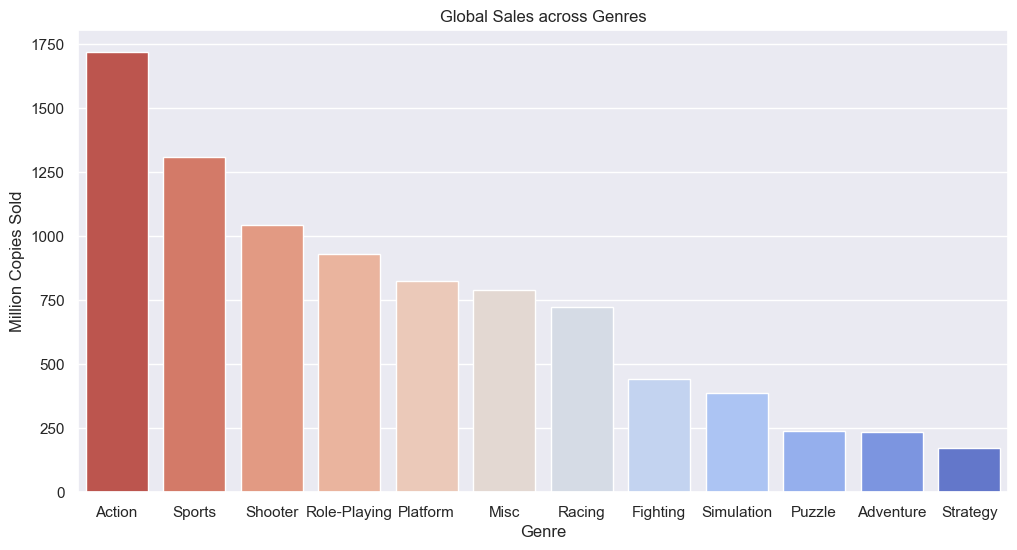

In [4]:
Sales_df = df.groupby('Genre')[['Global_Sales']].sum()
Sales_df = Sales_df.sort_values(by='Global_Sales', ascending=False)

plt.figure(figsize=(12, 6))
plt.title('Global Sales across Genres')
plt.ylabel('Million Copies Sold')
sns.barplot(data= Sales_df, x='Genre' , y= 'Global_Sales', palette="coolwarm_r")
plt.show()

Answer : As it's shown in the graph genres like Action, Sports and Shooter were the most popular with Global Sales over 1000 Million copies each.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Q1: Which platform was the sales leader over the years?

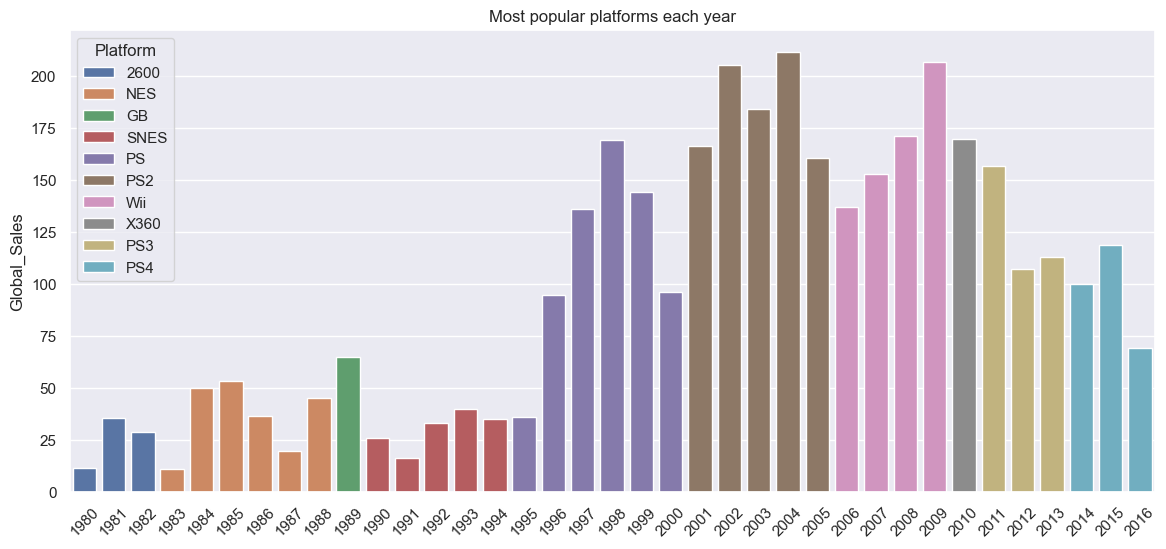

In [5]:
# Grouping by Year and Platform and separating values by the sum of Sales world wide
Plat_df = df.groupby(['Year_of_Release', 'Platform'])['Global_Sales'].sum().reset_index() 
leaders = Plat_df.loc[Plat_df.groupby('Year_of_Release')['Global_Sales'].idxmax()] 

plt.figure(figsize=(14, 6))
plt.title('Most popular platforms each year')
sns.barplot(data=leaders, x='Year_of_Release', y='Global_Sales', hue='Platform')
plt.xlabel(None)
plt.xticks(rotation=45)
plt.show()

Answer : Platforms like PS2, Wii, and later PS3 noticably dominated in different periods of time.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Q3: Is there a relationship between critic scores and sales?

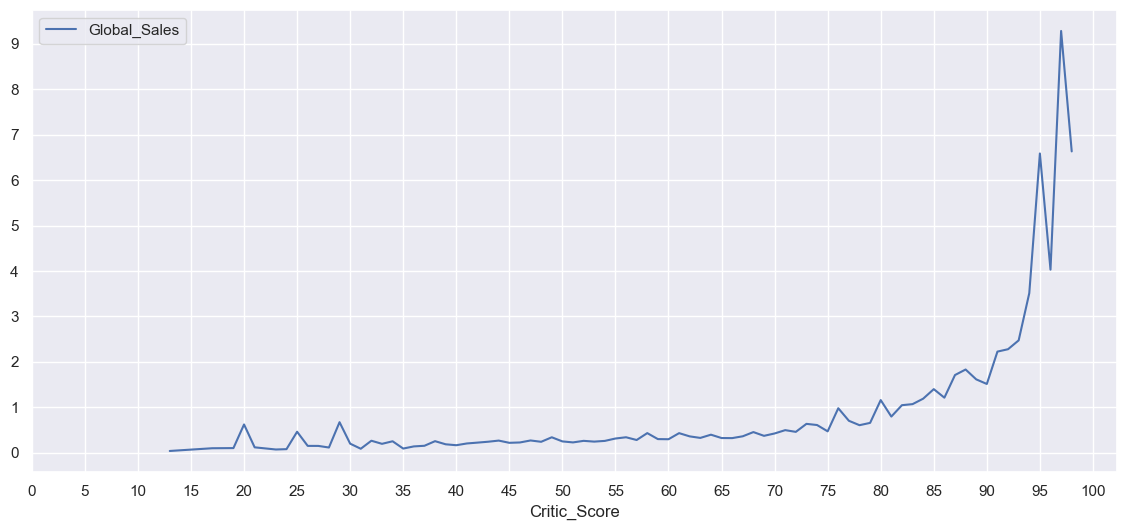

In [6]:
Critic_df = df.groupby('Critic_Score')[['Global_Sales']].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(Critic_df)
plt.xticks(range(0, 101, 5))
plt.yticks(range(0, int(Critic_df['Global_Sales'].max())+1))
plt.show()

Answer: Higher critic scores only slightly influence Global Sales, but after score is over 90 you can notice overwhelming rise of the Sales.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Q4: How are games distributed across ESRB age ratings?

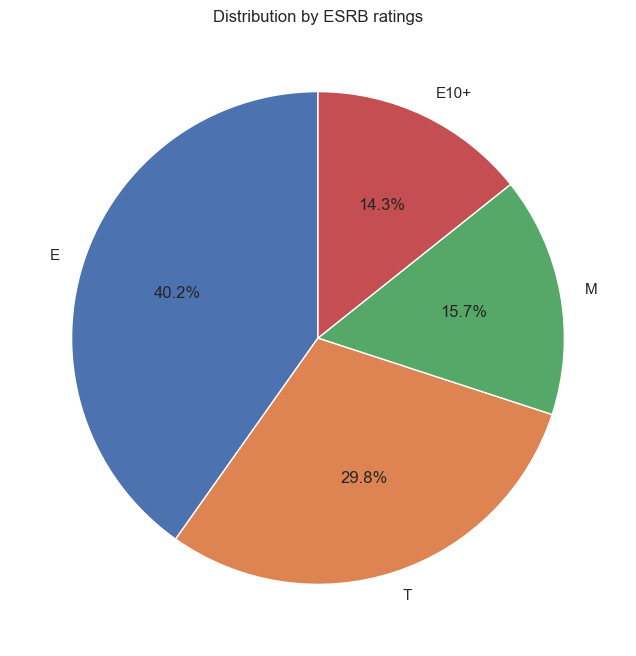

In [7]:
filtered_df = df[df["Rating"].isin(["E", "T", "M", "E10+"])] 

# pie chart using matplotlib
filtered_df["Rating"].value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(8,8), startangle=90) 
plt.title("Distribution by ESRB ratings")
plt.ylabel(None)
plt.show()


Answer: 70% of the games are rated E and T. M and E10+ have only 29% of the games, and since this 4 ratings are dominating and others are less than 1% we can drop them

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Machine Learning: Predicting Global Sales

#### The goal is to predict Global_Sales based on features like Platform, Genre, Release year, Critic/User scores and counts, and ESRB age Rating.

In [8]:
# importing ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

# Dividing data into predtion (y) and predictors (X)
X = df[['Platform', 'Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']]
y = df['Global_Sales']

# Spliting data into training and testing parts
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

# Determine column types
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['Int64', 'float64']]

# Fill empty data with Imputer for numerical columns
numerical_transformer = SimpleImputer(strategy='constant')

# For categorical we need to fill gaps and transform it into numerical values with OrdinalEncoder(no extra columns)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Fixing indexes with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
('num', numerical_transformer, numerical_cols),
('cat', categorical_transformer, categorical_cols)
    ])



#### If you want to check your data i left data1 dictionary which values you can customise and predict Global Sales

In [9]:
# Custom Data in case you want to test ur own values
data1 = {
    'Platform': ['PC'],
    'Year_of_Release' : [2010],
    'Genre' : ['Adventure'],
    'Critic_Score' : [79.0],
    'Critic_Count' : [100.0],
    'User_Score' : [94.0],
    'User_Count' : [100.0],
    'Rating' : ['T']
}

#### Now after data preparation we can train our model on it and check how accurate it is.

In [10]:
# importing models and metrics
from sklearn.ensemble import RandomForestRegressor # at first i tried with RandomForest but it was much less efficient than XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = XGBRegressor(n_estimators=70, learning_rate=0.1, n_jobs=4) # after multiple tests 70 n_estimators were the closest to the ideal

my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

# Training the model
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

score = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)
print('MAE: %.4f' %score)
print('R2: %.4f ' %r2)


MAE: 0.4273
R2: 0.2807 


MAE 0.42 is very good result it means that our model is pretty good in predicting.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Now i want to find out what column was the most important and the most influencing in predicting Global Sales.

I am gonna do it by using permutation_importance from sklearn and visualize it via bar chart.

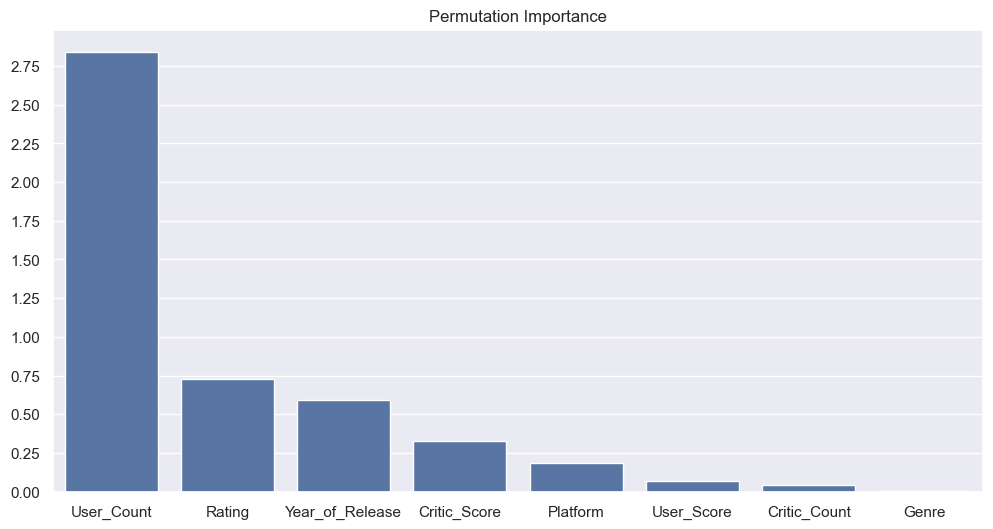

In [11]:
from sklearn.inspection import permutation_importance
import numpy as np

result = permutation_importance(my_pipeline, X_valid, y_valid, n_repeats=10, random_state=0)

perm_importances = pd.Series(result.importances_mean, index=X_valid.columns)
perm_importances.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0, 3, 0.25))
sns.barplot(perm_importances)
plt.title("Permutation Importance")
plt.show()


##### As we can see the amount of Users in release was the key factor in prediction which makes sense.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------